# Projekt

Udało mi się znaleźć archiwalne dane wypożyczalni filmów na DVD. Firma wypożyczająca płyty chce przewidzieć na ile dni klient będzie wypożyczać filmy. 

In [41]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [42]:
# Lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [43]:
# OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [44]:
# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

## 1. Wczytanie danych

In [45]:
df_rental = pd.read_csv("rental_info.csv")
df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [46]:
df_rental.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


## 2. Przetwarzanie danych

Kolumny 'rental_date' oznaczająca dzień wynajmu, oraz 'return_date' oznaczająca datę zwrotu obie mają dtype object. Przekonwertuję je do formatu datetime. Następnię stworzę nową kolumnę 'rental_length' w której zapiszę różnicę daty. Zaaokrąglę róznicę do pełnych dni, aby uzyskać ilość dni wynajmu płyty DVD.

In [47]:
# 2.1. Obliczanie długości wypożyczenia
df_rental["rental_length"] = pd.to_datetime(df_rental["return_date"]) - pd.to_datetime(df_rental["rental_date"])
df_rental["rental_length_days"] = df_rental["rental_length"].dt.days
df_rental.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length,rental_length_days
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3 days 20:46:00,3
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2 days 20:05:00,2
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7 days 05:44:00,7
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2 days 02:24:00,2
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4 days 01:05:00,4


In [48]:
# 2.2. Dodanie zmiennych zero-jedynkowych dla specjalnych cech
# Utworzenie dwóch kolumn zmiennych fikcyjnych ze 'special_features', które przyjmują wartość 1 (gdy wartość jest 'Deleted Scenes' przechowywana jako kolumna o nazwie 'deleted_scenes', oraz wartość jest 'Behind the scenes' przechowywana jako kolumna o nazwie 'bihand_the_scenes'.)
df_rental["deleted_scenes"] =  np.where(df_rental["special_features"].str.contains("Deleted Scenes"), 1, 0)
df_rental["behind_the_scenes"] =  np.where(df_rental["special_features"].str.contains("Behind the Scenes"), 1, 0)
df_rental.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3 days 20:46:00,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2 days 20:05:00,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7 days 05:44:00,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2 days 02:24:00,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4 days 01:05:00,4,0,1


In [49]:
# 2.3. Wybór kolumn do usunięcia
cols_to_drop = ["special_features", "rental_length", "rental_length_days", "rental_date", "return_date"]

In [50]:
# 2.4. Podział na zbiór cech (x) i zbiór docelowy(y)
X = df_rental.drop(cols_to_drop, axis=1)
y = df_rental["rental_length_days"]

In [51]:
# Podzielenie danych na zestaw treningowy i testowy, przy uwzględnieniu 20% całkowitych danych w zestawie testowym.
X_train,X_test,y_train,y_test = train_test_split(X, 
                                                 y, 
                                                 test_size=0.2, 
                                                 random_state=9)

In [70]:
X_train.head()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,deleted_scenes,behind_the_scenes
6682,2.99,2010.0,2.99,90.0,25.99,1,0,0,0,8.9401,8100.0,8.9401,0,1
8908,4.99,2008.0,0.99,53.0,25.99,1,0,0,0,24.9001,2809.0,0.9801,1,0
11827,6.99,2007.0,4.99,171.0,25.99,0,0,1,0,48.8601,29241.0,24.9001,0,1
6153,2.99,2010.0,2.99,73.0,29.99,0,0,0,1,8.9401,5329.0,8.9401,1,1
10713,5.99,2004.0,0.99,122.0,14.99,1,0,0,0,35.8801,14884.0,0.9801,1,0


### Regresja Lasso

In [52]:
# 1. Tworzenie modelu lasso
lasso = Lasso(alpha=0.3, random_state=9) 
lasso

Lasso(alpha=0.3, random_state=9)

In [53]:
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_
lasso_coef

array([ 5.84104424e-01,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  4.36220109e-02,  3.01167812e-06, -1.52983561e-01,
       -0.00000000e+00,  0.00000000e+00])

In [54]:
# 2. Selekcja cech za pomocą współczynników Lasso
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

In [55]:
# 3. Regresja liniowa na wybranych cechach:
ols = LinearRegression()
ols = ols.fit(X_lasso_train, y_train)
y_test_pred = ols.predict(X_lasso_test)
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)
mse_lin_reg_lasso

4.812297241276244

### Las losowy z optymalizacją hiperparametrów

In [56]:
# 1. Przestrzeń hiperparametrów:
param_dist = {'n_estimators': np.arange(1,101,1),
          'max_depth':np.arange(1,11,1)}

In [57]:
# 2. Tworzenie modelu lasu losowego:
rf = RandomForestRegressor()

In [58]:
# 3. Tworzenie modelu lasu losowego:
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 cv=5, 
                                 random_state=9)
rand_search.fit(X_train, y_train)
hyper_params = rand_search.best_params_
hyper_params

{'n_estimators': 51, 'max_depth': 10}

In [59]:
rand_search

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   random_state=9)

In [60]:
# 4. Tworzenie modelu lasu losowego z najlepszymi hiperparametrami:
rf = RandomForestRegressor(n_estimators=hyper_params["n_estimators"], 
                           max_depth=hyper_params["max_depth"], 
                           random_state=9)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
mse_random_forest= mean_squared_error(y_test, rf_pred)

### Wybór najlepszego modelu

In [61]:
best_model = rf
best_mse = mse_random_forest

## Wizualizacja błędów predykcji

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# Wartości przewidywane przez najlepszy model
y_pred = best_model.predict(X_test)

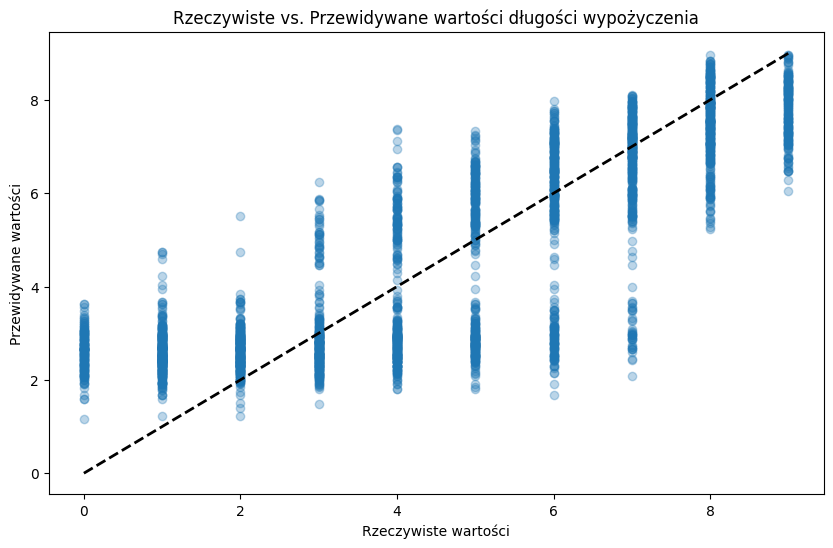

In [64]:
# Wykres rozrzutu rzeczywiste vs. przewidywane wartości
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Rzeczywiste vs. Przewidywane wartości długości wypożyczenia')
plt.show()

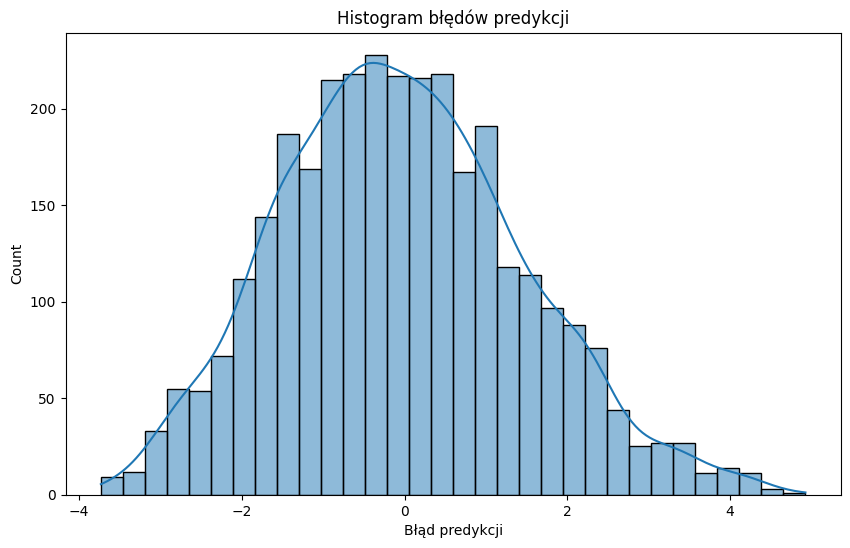

In [65]:
# Histogram błędów (reszt)
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Błąd predykcji')
plt.title('Histogram błędów predykcji')
plt.show()

In [66]:
# Ważność cech w modelu lasu losowego
importances = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

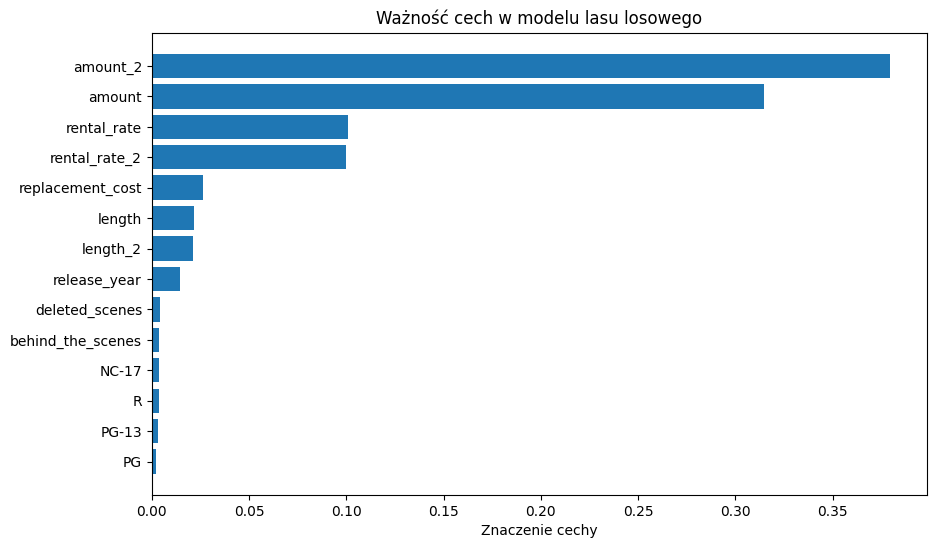

In [67]:
plt.figure(figsize=(10, 6))
plt.title('Ważność cech w modelu lasu losowego')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Znaczenie cechy')
plt.show()

In [78]:
# Przykładowe nowe dane
new_data = pd.DataFrame({
    'amount': [2.99],
    'release_year': [2010.0],
    'rental_rate': [2.99],
    'length': [90.0],
    'replacement_cost': [25.99],
    'NC-17': [1],
    'PG': [0],
    'PG-13': [0],
    'R': [0],
    'amount_2': [8.9401],
    'length_2': [8100.0],
    'rental_rate_2': [8.9401],
    'deleted_scenes': [0],
    'behind_the_scenes': [1],

})

# Przewidywanie długości wypożyczenia za pomocą wytrenowanego modelu
predicted_rental_length = best_model.predict(new_data)
print(predicted_rental_length)

# Dodanie przewidywanych wartości do DataFrame
new_data['predicted_rental_length'] = predicted_rental_length

print(new_data)

[2.97337595]
   amount  release_year  rental_rate  length  replacement_cost  NC-17  PG  \
0    2.99        2010.0         2.99    90.0             25.99      1   0   

   PG-13  R  amount_2  length_2  rental_rate_2  deleted_scenes  \
0      0  0    8.9401    8100.0         8.9401               0   

   behind_the_scenes  predicted_rental_length  
0                  1                 2.973376  
